In [560]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [660]:
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection  
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn import metrics
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns 
sns.set_palette('muted')
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [562]:
import lightgbm as lgb

In [563]:
pd.set_option('display.max_columns', None)

In [564]:
LogInfo = pd.read_csv('PPD_LogInfo_3_1_Training_Set.csv')
Master = pd.read_csv('PPD_Training_Master_GBK_3_1_Training_Set.csv',encoding = 'utf-8')
Userupdate = pd.read_csv('PPD_Userupdate_Info_3_1_Training_Set.csv')

# 一、数据清洗

In [565]:
Master['target'].value_counts()

0    27802
1     2198
Name: target, dtype: int64

### 接下来我们需要先看一下缺失的情况，这个时候，要先确定原数据集是否已经做了缺失值补全，比如ThirdParty部分原本已经使用了-1补全缺失值，其他类型的特征缺失值为空；那么为了方便我们统一进行处理，就先把ThirdParty的-1替换为nan。

In [566]:
Master=Master.replace({-1:np.nan})

### 筛选出缺失率>80%的特征

In [567]:
col=Master.columns
drop_list_missing=[]
for i in col:
    if Master[i].count()/Master.shape[0]<0.2:
        drop_list_missing.append(i)

### 筛选出单类别比例大于95%的特征，这一类特征的区分能力会很弱。

In [568]:
drop_list_const=[]
for i in col:
    if i != 'target':
        if Master[i].value_counts().iloc[0]/Master[i].count()>0.95:
            drop_list_const.append(i)

### 把这两个要删除的特征列的名称合并，然后把这些特征从Master里面剔除掉

In [569]:
drop_list=list(set(drop_list_missing+drop_list_const))
Master=Master.drop(drop_list,axis=1)

### 再看一下每个样本的缺失特征的数量，单个样本如果缺失了太多的特征，会对模型产生较大影响，然后顺便将每个样本的缺失特征数量也衍生为一个特征

Text(0.5, 0, 'samples')

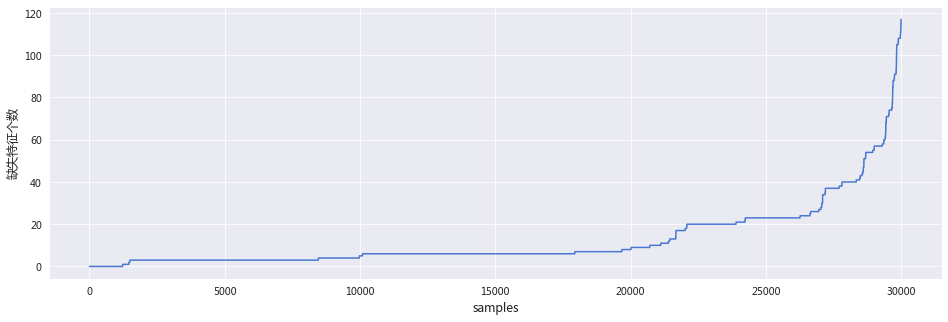

In [570]:
plt_size=(16,5)
Master['usermissing']=Master.isnull().sum(axis=1) # 衍生
list_missing_num  = sorted(list(Master['usermissing'].values))
plt.figure(figsize=plt_size)
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(range(Master.shape[0]),list_missing_num)
plt.ylabel('缺失特征个数')
plt.xlabel('samples')

### 把特征数缺失量达到60以上的数据也一并删除

In [571]:
Master=Master[~Master['Idx'].isin(Master[Master['usermissing']>80]['Idx'])]

In [572]:
Master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29687 entries, 0 to 29999
Columns: 160 entries, Idx to usermissing
dtypes: float64(142), int64(1), object(17)
memory usage: 36.5+ MB


# 二、特征工程

### 接下来看一下Master里面具体包含了哪些特征，咱们做个分类。

In [573]:
Master_feature_kind=pd.DataFrame({'feature_kind':[i.split('_',1)[0] for i in Master.columns],'cnt':1})
Master_feature_kind.groupby('feature_kind',as_index=False)['cnt'].count().sort_values(by='cnt')

,feature_kind,cnt
1,Idx,1
2,ListingInfo,1
7,target,1
8,usermissing,1
0,Education,4
3,SocialNetwork,6
6,WeblogInfo,20
5,UserInfo,24
4,ThirdParty,102


### 可以看到master表中总共包含五类特征，即UserInfo,WeblogInfo,SocialNetwork,Education和ThirdParty，我会按照这五个类别来分别进行处理；

### 由于分类特征相比数值特征一般需要特殊处理，再看下哪些是分类特征，分别属于五类特征中的哪些。

In [574]:
for i in Master.columns:
    if Master[i].dtype=='object':
        print (i)

UserInfo_2
UserInfo_4
UserInfo_7
UserInfo_8
UserInfo_9
UserInfo_19
UserInfo_20
UserInfo_22
UserInfo_23
UserInfo_24
Education_Info2
Education_Info3
Education_Info4
WeblogInfo_19
WeblogInfo_20
WeblogInfo_21
ListingInfo


## 1、UserInfo
### 由于UserInfo里面的有一些值为中文的特征，所以可以推断一下特征含义，UserInfo_7、UserInfo_8、UserInfo_9应该是运营商名称及号码归属地，UserInfo_19、UserInfo_20应该是户口所在地，因为后面紧跟了婚姻情况；代表了地区的特征有6个，其中2个省级4个市级，有2个地区特征是有缺失的，观察到另外4个已经使用了‘不详’作为缺失填充值，那么我们做到统一。

In [575]:
Master['UserInfo_2']=Master['UserInfo_2'].replace({np.nan:'不详'})
Master['UserInfo_4']=Master['UserInfo_4'].replace({np.nan:'不详'})

In [576]:
#将“市”截取掉
Master['UserInfo_2']=Master['UserInfo_2'].map(lambda x: x[:-1] if x.find('市')>0 else x)
Master['UserInfo_4']=Master['UserInfo_4'].map(lambda x: x[:-1] if x.find('市')>0 else x)
Master['UserInfo_8']=Master['UserInfo_8'].map(lambda x: x[:-1] if x.find('市')>0 else x)
Master['UserInfo_20']=Master['UserInfo_20'].map(lambda x: x[:-1] if x.find('市')>0 else x)

### 省份特征枚举，确定哪些省份多了“尾巴”。只保留省级名称，省略后面的“省”，“市”以及各种自治区名称。

In [577]:
Master['UserInfo_19'].unique()

array(['四川省', '福建省', '湖北省', '江西省', '辽宁省', '山东省', '内蒙古自治区', '湖南省', '黑龙江省',
       '山西省', '江苏省', '云南省', '浙江省', '广东省', '天津市', '广西壮族自治区', '甘肃省', '陕西省',
       '重庆市', '河北省', '青海省', '安徽省', '上海市', '吉林省', '贵州省', '北京市', '河南省',
       '宁夏回族自治区', '新疆维吾尔自治区', '海南省', '西藏自治区'], dtype=object)

In [578]:
Master['UserInfo_19']=Master['UserInfo_19'].map(lambda x: x[:-1] if x.find('省')>0 else x)
Master['UserInfo_19']=Master['UserInfo_19'].map(lambda x: x[:-1] if x.find('市')>0 else x)
Master['UserInfo_19']=Master['UserInfo_19'].map(lambda x: x[:-5] if x.find('壮族自治区')>0 else x)
Master['UserInfo_19']=Master['UserInfo_19'].map(lambda x: x[:-5] if x.find('回族自治区')>0 else x)
Master['UserInfo_19']=Master['UserInfo_19'].map(lambda x: x[:-6] if x.find('维吾尔自治区')>0 else x)
Master['UserInfo_19']=Master['UserInfo_19'].map(lambda x: x[:-3] if x.find('自治区')>0 else x)

### 下面是对于省份特征的二值化，具体为：将逾期率前五的特征筛选出来，然后构造“是否为xx省”的特征。

In [579]:
#逾期率前五省份UserInfo_7
a=pd.DataFrame()
a['total']=Master.groupby('UserInfo_7')['target'].count()
a['bad']=Master.groupby('UserInfo_7')['target'].sum()
a['bad_rate']=a['bad']/a['total']
a.sort_values('bad_rate',ascending=False).iloc[0:5,-1]

UserInfo_7
山东    0.109428
天津    0.109290
四川    0.096861
湖南    0.094286
海南    0.091463
Name: bad_rate, dtype: float64

In [580]:
#逾期率前五省份UserInfo_19
a=pd.DataFrame()
a['total']=Master.groupby('UserInfo_19')['target'].count()
a['bad']=Master.groupby('UserInfo_19')['target'].sum()
a['bad_rate']=a['bad']/a['total']
a.sort_values('bad_rate',ascending=False).iloc[0:5,-1]

UserInfo_19
天津     0.125000
山东     0.108131
吉林     0.095142
黑龙江    0.087438
辽宁     0.085546
Name: bad_rate, dtype: float64

In [581]:
#逾期率前五省份二值化
Master['UserInfo_7_shandong']=Master['UserInfo_7'].map(lambda x: 1 if x=='山东' else 0)
Master['UserInfo_7_tianjin']=Master['UserInfo_7'].map(lambda x: 1 if x=='天津' else 0)
Master['UserInfo_7_sichaun']=Master['UserInfo_7'].map(lambda x: 1 if x=='四川' else 0)
Master['UserInfo_7_hunan']=Master['UserInfo_7'].map(lambda x: 1 if x=='湖南' else 0)
Master['UserInfo_7_hainan']=Master['UserInfo_7'].map(lambda x: 1 if x=='海南' else 0)
#---------------------------------------------------------------------------------
Master['UserInfo_19_xizang']=Master['UserInfo_19'].map(lambda x: 1 if x=='天津' else 0)
Master['UserInfo_19_shandong']=Master['UserInfo_19'].map(lambda x: 1 if x=='山东' else 0)
Master['UserInfo_19_jilin']=Master['UserInfo_19'].map(lambda x: 1 if x=='吉林' else 0)
Master['UserInfo_19_heilongjiang']=Master['UserInfo_19'].map(lambda x: 1 if x=='黑龙江' else 0)
Master['UserInfo_19_liaoning']=Master['UserInfo_19'].map(lambda x: 1 if x=='辽宁' else 0)

### 下面是对于市特征的二值化，具体为：构造“是否是x线城市”特征。

In [582]:
top_order_city = ['北京','上海','广州','深圳']
first_order_city = ['成都','重庆','杭州','武汉','西安','天津','苏州','南京','郑州','长沙','东莞','沈阳','青岛','合肥','佛山']

In [583]:
#城市分级化
Master['UserInfo_2_top']=Master['UserInfo_2'].map(lambda x: 1 if x in top_order_city else 0)
Master['UserInfo_2_first']=Master['UserInfo_2'].map(lambda x: 1 if x in first_order_city else 0)
Master['UserInfo_2_other']=Master['UserInfo_2'].map(lambda x: 1 if (x not in top_order_city and x not in first_order_city) else 0)
#---------------------------------------------------------------------------------
Master['UserInfo_4_top']=Master['UserInfo_4'].map(lambda x: 1 if x in top_order_city else 0)
Master['UserInfo_4_first']=Master['UserInfo_4'].map(lambda x: 1 if x in first_order_city else 0)
Master['UserInfo_4_other']=Master['UserInfo_4'].map(lambda x: 1 if (x not in top_order_city and x not in first_order_city) else 0)
#---------------------------------------------------------------------------------
Master['UserInfo_8_top']=Master['UserInfo_8'].map(lambda x: 1 if x in top_order_city else 0)
Master['UserInfo_8_first']=Master['UserInfo_8'].map(lambda x: 1 if x in first_order_city else 0)
Master['UserInfo_8_other']=Master['UserInfo_8'].map(lambda x: 1 if (x not in top_order_city and x not in first_order_city) else 0)
#---------------------------------------------------------------------------------
Master['UserInfo_20_first']=Master['UserInfo_20'].map(lambda x: 1 if x in top_order_city else 0)
Master['UserInfo_20_first']=Master['UserInfo_20'].map(lambda x: 1 if x in first_order_city else 0)
Master['UserInfo_20_other']=Master['UserInfo_20'].map(lambda x: 1 if (x not in top_order_city and x not in first_order_city) else 0)


### 下面对于同级别的地区特征做暴力衍生，四个城市之间两两不同做衍生，省份不同做衍生，总共衍生出6个。

In [584]:
Master['different_2_4']=np.where((Master['UserInfo_2']==Master['UserInfo_4']),0,1)
Master['different_2_8']=np.where((Master['UserInfo_2']==Master['UserInfo_8']),0,1)
Master['different_2_20']=np.where((Master['UserInfo_2']==Master['UserInfo_20']),0,1)
Master['different_4_8']=np.where((Master['UserInfo_4']==Master['UserInfo_8']),0,1)
Master['different_4_20']=np.where((Master['UserInfo_4']==Master['UserInfo_20']),0,1)
Master['different_8_20']=np.where((Master['UserInfo_8']==Master['UserInfo_20']),0,1)
Master['different_7_19']=np.where((Master['UserInfo_7']==Master['UserInfo_19']),0,1)

### 下面两个是基于特征含义和个人判断做的地区特征衍生

In [585]:
#户籍地与现在的两个地址都不同
Master['different_20_2_4']=np.where((Master['UserInfo_2']==Master['UserInfo_20']) | (Master['UserInfo_4']==Master['UserInfo_20']),0,1)
#运营商归属地与所有地址都不同
Master['different_8_2_4_20']=np.where((Master['UserInfo_8']==Master['UserInfo_2']) | (Master['UserInfo_8']==Master['UserInfo_4']) | (Master['UserInfo_8']==Master['UserInfo_20']),0,1)


### 删除已经经过处理的地址信息列

In [586]:
Master = Master.drop('UserInfo_7',1)
Master = Master.drop('UserInfo_19',1)
Master = Master.drop('UserInfo_2',1)
Master = Master.drop('UserInfo_4',1)
Master = Master.drop('UserInfo_8',1)
Master = Master.drop('UserInfo_20',1)

In [587]:
Master.head()

,Idx,UserInfo_1,UserInfo_3,WeblogInfo_2,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,UserInfo_5,UserInfo_6,UserInfo_9,UserInfo_10,UserInfo_11,UserInfo_12,UserInfo_13,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_21,UserInfo_22,UserInfo_23,UserInfo_24,Education_Info1,Education_Info2,Education_Info3,Education_Info4,WeblogInfo_19,WeblogInfo_20,WeblogInfo_21,WeblogInfo_24,WeblogInfo_27,WeblogInfo_30,WeblogInfo_33,WeblogInfo_36,WeblogInfo_39,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_2,ThirdParty_Info_Period2_3,ThirdParty_Info_Period2_4,ThirdParty_Info_Period2_5,ThirdParty_Info_Period2_6,ThirdParty_Info_Period2_7,ThirdParty_Info_Period2_8,ThirdParty_Info_Period2_9,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,ThirdParty_Info_Period2_12,ThirdParty_Info_Period2_13,ThirdParty_Info_Period2_14,ThirdParty_Info_Period2_15,ThirdParty_Info_Period2_16,ThirdParty_Info_Period2_17,ThirdParty_Info_Period3_1,ThirdParty_Info_Period3_2,ThirdParty_Info_Period3_3,ThirdParty_Info_Period3_4,ThirdParty_Info_Period3_5,ThirdParty_Info_Period3_6,ThirdParty_Info_Period3_7,ThirdParty_Info_Period3_8,ThirdParty_Info_Period3_9,ThirdParty_Info_Period3_10,ThirdParty_Info_Period3_11,ThirdParty_Info_Period3_12,ThirdParty_Info_Period3_13,ThirdParty_Info_Period3_14,ThirdParty_Info_Period3_15,ThirdParty_Info_Period3_16,ThirdParty_Info_Period3_17,ThirdParty_Info_Period4_1,ThirdParty_Info_Period4_2,ThirdParty_Info_Period4_3,ThirdParty_Info_Period4_4,ThirdParty_Info_Period4_5,ThirdParty_Info_Period4_6,ThirdParty_Info_Period4_7,ThirdParty_Info_Period4_8,ThirdParty_Info_Period4_9,ThirdParty_Info_Period4_10,ThirdParty_Info_Period4_11,ThirdParty_Info_Period4_12,ThirdParty_Info_Period4_13,ThirdParty_Info_Period4_14,ThirdParty_Info_Period4_15,ThirdParty_Info_Period4_16,ThirdParty_Info_Period4_17,ThirdParty_Info_Period5_1,ThirdParty_Info_Period5_2,ThirdParty_Info_Period5_3,ThirdParty_Info_Period5_4,ThirdParty_Info_Period5_5,ThirdParty_Info_Period5_6,ThirdParty_Info_Period5_7,ThirdParty_Info_Period5_8,ThirdParty_Info_Period5_9,ThirdParty_Info_Period5_10,ThirdParty_Info_Period5_11,ThirdParty_Info_Period5_12,ThirdParty_Info_Period5_13,ThirdParty_Info_Period5_14,ThirdParty_Info_Period5_15,ThirdParty_Info_Period5_16,ThirdParty_Info_Period5_17,ThirdParty_Info_Period6_1,ThirdParty_Info_Period6_2,ThirdParty_Info_Period6_3,ThirdParty_Info_Period6_4,ThirdParty_Info_Period6_5,ThirdParty_Info_Period6_6,ThirdParty_Info_Period6_7,ThirdParty_Info_Period6_8,ThirdParty_Info_Period6_9,ThirdParty_Info_Period6_10,ThirdParty_Info_Period6_11,ThirdParty_Info_Period6_12,ThirdParty_Info_Period6_13,ThirdParty_Info_Period6_14,ThirdParty_Info_Period6_15,ThirdParty_Info_Period6_16,ThirdParty_Info_Period6_17,SocialNetwork_8,SocialNetwork_9,SocialNetwork_10,SocialNetwork_13,SocialNetwork_14,SocialNetwork_17,target,ListingInfo,usermissing,UserInfo_7_shandong,UserInfo_7_tianjin,UserInfo_7_sichaun,UserInfo_7_hunan,UserInfo_7_hainan,UserInfo_19_xizang,UserInfo_19_shandong,UserInfo_19_jilin,UserInfo_19_heilongjiang,UserInfo_19_liaoning,UserInfo_2_top,UserInfo_2_first,UserInfo_2_other,UserInfo_4_top,UserInfo_4_first,UserInfo_4_other,UserInfo_8_top,UserInfo_8_first,UserInfo_8_other,UserInfo_20_first,UserInfo_20_other,different_2_4,different_2_8,different_2_20,different_4_8,different_4_20,different_8_20,different_7_19,different_20_2_4,different_8_2_4_20
0,10001.0,1.0,4.0,1.0,1.0,1.0,1.0,14.0,0.0,6.0,6.0,0.0,6.0,2.0,2.0,2.0,中国移动,0.0,NaN,NaN,NaN,2.0,2

### 运营商特征枚举后发现，存在七个不同的值，理论上是只有四个的（三大运营商+缺失），原因是部分特征值包含了空格，把空格去掉就行。

In [588]:
Master['UserInfo_9']=Master['UserInfo_9'].map(lambda x:x.split(' ',1)[0])

In [589]:
Master['UserInfo_9'].unique()

array(['中国移动', '中国电信', '不详', '中国联通'], dtype=object)

In [590]:
Master['UserInfo_9_yidong']=Master['UserInfo_9'].map(lambda x: 1 if x == '中国移动' else 0)
Master['UserInfo_9_liantong']=Master['UserInfo_9'].map(lambda x: 1 if x == '中国联通' else 0)
Master['UserInfo_9_dianxin']=Master['UserInfo_9'].map(lambda x: 1 if x == '中国电信' else 0)
Master['UserInfo_9_unknown']=Master['UserInfo_9'].map(lambda x: 1 if x == '不详' else 0)

In [591]:
Master = Master.drop('UserInfo_9',1)

### 处理UserInfo中其余含有中文的列：UserInfo_22、UserInfo_23、UserInfo_24
### UserInfo_22

In [592]:
Master['UserInfo_22'].isna().sum()

0

In [593]:
Master['UserInfo_22'].value_counts()

D     27581
未婚     1311
已婚      464
不详      293
离婚       33
再婚        4
初婚        1
Name: UserInfo_22, dtype: int64

### UserInfo_22是结婚情况，没有缺失项，可以采用独热编码

In [594]:
Master['UserInfo_22_D']=Master['UserInfo_22'].map(lambda x: 1 if x == 'D' else 0)
Master['UserInfo_22_weihun']=Master['UserInfo_22'].map(lambda x: 1 if x == '未婚' else 0)
Master['UserInfo_22_yihun']=Master['UserInfo_22'].map(lambda x: 1 if x == '已婚' else 0)
Master['UserInfo_22_buxiang']=Master['UserInfo_22'].map(lambda x: 1 if x == '不详' else 0)
Master['UserInfo_22_lihun']=Master['UserInfo_22'].map(lambda x: 1 if x == '离婚' else 0)
Master['UserInfo_22_zaihun']=Master['UserInfo_22'].map(lambda x: 1 if x == '再婚' else 0)
Master['UserInfo_22_chuhun']=Master['UserInfo_22'].map(lambda x: 1 if x == '初婚' else 0)

In [595]:
Master = Master.drop('UserInfo_22',1)

### UserInfo_23

In [596]:
Master['UserInfo_23'].isna().sum()

0

In [597]:
Master['UserInfo_23'].value_counts()

D             27581
G               608
AB              334
O               296
大学本科（简称“大学      165
M               142
不详              135
AK               84
H                69
Y                50
专科毕业             46
K                38
P                36
AI               28
AC               19
W                11
AE               10
AJ                8
AH                8
Q                 7
R                 4
AD                3
X                 1
AP                1
AF                1
Z                 1
AL                1
Name: UserInfo_23, dtype: int64

### UserInfo_23是学历情况，同样没有缺失项，但是种类多，选取前5做独热编码

In [598]:
Master['UserInfo_23_D']=Master['UserInfo_23'].map(lambda x: 1 if x == 'D' else 0)
Master['UserInfo_23_G']=Master['UserInfo_23'].map(lambda x: 1 if x == 'G' else 0)
Master['UserInfo_23_AB']=Master['UserInfo_23'].map(lambda x: 1 if x == 'AB' else 0)
Master['UserInfo_23_O']=Master['UserInfo_23'].map(lambda x: 1 if x == 'O' else 0)
Master['UserInfo_23_DXBK']=Master['UserInfo_23'].map(lambda x: 1 if x == '大学本科（简称“大学' else 0)

In [599]:
Master = Master.drop('UserInfo_23',1)

### UserInfo_24

In [600]:
Master['UserInfo_24'].isna().sum()

0

In [601]:
Master['UserInfo_24'].value_counts()

D              27581
浙江省温州市苍南县          5
上海市浦东新区            4
山东省菏泽市牡丹区          4
湖南省衡阳市耒阳市          4
               ...  
河南省林州市水车园村         1
山西省临汾市乡宁县          1
江苏省徐州市睢宁县          1
山西省阳泉市郊区荫营镇        1
罗家镇胡坊村             1
Name: UserInfo_24, Length: 1943, dtype: int64

### 看着像是老家，D变量为主要，可以用0/1编码

In [602]:
Master['UserInfo_24']=Master['UserInfo_24'].map(lambda x: 1 if x == 'D' else 0)

### 其余的缺失信息用中位数填补

In [603]:
Master.head()

,Idx,UserInfo_1,UserInfo_3,WeblogInfo_2,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,UserInfo_5,UserInfo_6,UserInfo_10,UserInfo_11,UserInfo_12,UserInfo_13,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_21,UserInfo_24,Education_Info1,Education_Info2,Education_Info3,Education_Info4,WeblogInfo_19,WeblogInfo_20,WeblogInfo_21,WeblogInfo_24,WeblogInfo_27,WeblogInfo_30,WeblogInfo_33,WeblogInfo_36,WeblogInfo_39,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_2,ThirdParty_Info_Period2_3,ThirdParty_Info_Period2_4,ThirdParty_Info_Period2_5,ThirdParty_Info_Period2_6,ThirdParty_Info_Period2_7,ThirdParty_Info_Period2_8,ThirdParty_Info_Period2_9,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,ThirdParty_Info_Period2_12,ThirdParty_Info_Period2_13,ThirdParty_Info_Period2_14,ThirdParty_Info_Period2_15,ThirdParty_Info_Period2_16,ThirdParty_Info_Period2_17,ThirdParty_Info_Period3_1,ThirdParty_Info_Period3_2,ThirdParty_Info_Period3_3,ThirdParty_Info_Period3_4,ThirdParty_Info_Period3_5,ThirdParty_Info_Period3_6,ThirdParty_Info_Period3_7,ThirdParty_Info_Period3_8,ThirdParty_Info_Period3_9,ThirdParty_Info_Period3_10,ThirdParty_Info_Period3_11,ThirdParty_Info_Period3_12,ThirdParty_Info_Period3_13,ThirdParty_Info_Period3_14,ThirdParty_Info_Period3_15,ThirdParty_Info_Period3_16,ThirdParty_Info_Period3_17,ThirdParty_Info_Period4_1,ThirdParty_Info_Period4_2,ThirdParty_Info_Period4_3,ThirdParty_Info_Period4_4,ThirdParty_Info_Period4_5,ThirdParty_Info_Period4_6,ThirdParty_Info_Period4_7,ThirdParty_Info_Period4_8,ThirdParty_Info_Period4_9,ThirdParty_Info_Period4_10,ThirdParty_Info_Period4_11,ThirdParty_Info_Period4_12,ThirdParty_Info_Period4_13,ThirdParty_Info_Period4_14,ThirdParty_Info_Period4_15,ThirdParty_Info_Period4_16,ThirdParty_Info_Period4_17,ThirdParty_Info_Period5_1,ThirdParty_Info_Period5_2,ThirdParty_Info_Period5_3,ThirdParty_Info_Period5_4,ThirdParty_Info_Period5_5,ThirdParty_Info_Period5_6,ThirdParty_Info_Period5_7,ThirdParty_Info_Period5_8,ThirdParty_Info_Period5_9,ThirdParty_Info_Period5_10,ThirdParty_Info_Period5_11,ThirdParty_Info_Period5_12,ThirdParty_Info_Period5_13,ThirdParty_Info_Period5_14,ThirdParty_Info_Period5_15,ThirdParty_Info_Period5_16,ThirdParty_Info_Period5_17,ThirdParty_Info_Period6_1,ThirdParty_Info_Period6_2,ThirdParty_Info_Period6_3,ThirdParty_Info_Period6_4,ThirdParty_Info_Period6_5,ThirdParty_Info_Period6_6,ThirdParty_Info_Period6_7,ThirdParty_Info_Period6_8,ThirdParty_Info_Period6_9,ThirdParty_Info_Period6_10,ThirdParty_Info_Period6_11,ThirdParty_Info_Period6_12,ThirdParty_Info_Period6_13,ThirdParty_Info_Period6_14,ThirdParty_Info_Period6_15,ThirdParty_Info_Period6_16,ThirdParty_Info_Period6_17,SocialNetwork_8,SocialNetwork_9,SocialNetwork_10,SocialNetwork_13,SocialNetwork_14,SocialNetwork_17,target,ListingInfo,usermissing,UserInfo_7_shandong,UserInfo_7_tianjin,UserInfo_7_sichaun,UserInfo_7_hunan,UserInfo_7_hainan,UserInfo_19_xizang,UserInfo_19_shandong,UserInfo_19_jilin,UserInfo_19_heilongjiang,UserInfo_19_liaoning,UserInfo_2_top,UserInfo_2_first,UserInfo_2_other,UserInfo_4_top,UserInfo_4_first,UserInfo_4_other,UserInfo_8_top,UserInfo_8_first,UserInfo_8_other,UserInfo_20_first,UserInfo_20_other,different_2_4,different_2_8,different_2_20,different_4_8,different_4_20,different_8_20,different_7_19,different_20_2_4,different_8_2_4_20,UserInfo_9_yidong,UserInfo_9_liantong,UserInfo_9_dianxin,UserInfo_9_unknown,UserInfo_22_D,UserInfo_22_weihun,UserInfo_22_yihun,UserI

In [604]:
UserInfo_list=[i for i in Master.columns if i.split('_',1)[0]=='UserInfo']
for i in UserInfo_list:
    Master[i]=Master[i].fillna(Master[i].median())

## 2、WeblogInfo
### 查看下缺失情况以及特征类型

In [605]:
WeblogInfo_list=[i for i in Master.columns if i.split('_',1)[0]=='WeblogInfo']
Master[WeblogInfo_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29687 entries, 0 to 29999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   WeblogInfo_2   28047 non-null  float64
 1   WeblogInfo_4   28054 non-null  float64
 2   WeblogInfo_5   28054 non-null  float64
 3   WeblogInfo_6   28054 non-null  float64
 4   WeblogInfo_7   29687 non-null  float64
 5   WeblogInfo_8   29687 non-null  float64
 6   WeblogInfo_14  29687 non-null  float64
 7   WeblogInfo_15  29687 non-null  float64
 8   WeblogInfo_16  29687 non-null  float64
 9   WeblogInfo_17  29687 non-null  float64
 10  WeblogInfo_18  29687 non-null  float64
 11  WeblogInfo_19  26776 non-null  object 
 12  WeblogInfo_20  21729 non-null  object 
 13  WeblogInfo_21  26665 non-null  object 
 14  WeblogInfo_24  29436 non-null  float64
 15  WeblogInfo_27  29436 non-null  float64
 16  WeblogInfo_30  29436 non-null  float64
 17  WeblogInfo_33  29436 non-null  float64
 18  Weblog

In [606]:
#三个有缺失的正好是分类特征，我们使用众数填充。
for i in ['WeblogInfo_19','WeblogInfo_20','WeblogInfo_21']:
    Master[i]=Master[i].fillna(Master[i].mode()[0])

In [607]:
#剩下的浮点数类型数据空缺用中值填补。

for i in WeblogInfo_list:
    if i not in ['WeblogInfo_19','WeblogInfo_20','WeblogInfo_21']:
        Master[i]=Master[i].fillna(Master[i].median())

## 3、Education
### 查看下缺失情况以及特征类型

In [608]:
Education_list=[i for i in Master.columns if i.split('_',1)[0]=='Education']
Master[Education_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29687 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Education_Info1  29687 non-null  float64
 1   Education_Info2  29687 non-null  object 
 2   Education_Info3  29687 non-null  object 
 3   Education_Info4  29687 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


### 有三个分类特征，但是无法推断出特征含义。

In [609]:
Master['Education_Info2'].value_counts()

E     27810
A       947
AM      704
AQ      102
AN       75
U        44
B         5
Name: Education_Info2, dtype: int64

In [610]:
Master['Education_Info2_E']=Master['Education_Info2'].map(lambda x: 1 if x == 'E' else 0)
Master['Education_Info2_A']=Master['Education_Info2'].map(lambda x: 1 if x == 'A' else 0)
Master['Education_Info2_AM']=Master['Education_Info2'].map(lambda x: 1 if x == 'AM' else 0)
Master['Education_Info2_AQ']=Master['Education_Info2'].map(lambda x: 1 if x == 'AQ' else 0)
Master['Education_Info2_AN']=Master['Education_Info2'].map(lambda x: 1 if x == 'AN' else 0)
Master['Education_Info2_U']=Master['Education_Info2'].map(lambda x: 1 if x == 'U' else 0)
Master['Education_Info2_B']=Master['Education_Info2'].map(lambda x: 1 if x == 'B' else 0)

In [611]:
Master = Master.drop('Education_Info2',1)

In [612]:
Master['Education_Info3'].value_counts()

E     27810
毕业     1824
结业       53
Name: Education_Info3, dtype: int64

In [613]:
Master['Education_Info3_E']=Master['Education_Info3'].map(lambda x: 1 if x == 'E' else 0)
Master['Education_Info3_biye']=Master['Education_Info3'].map(lambda x: 1 if x == '毕业' else 0)
Master['Education_Info3_jieye']=Master['Education_Info3'].map(lambda x: 1 if x == '结业' else 0)

In [614]:
Master = Master.drop('Education_Info3',1)

In [615]:
Master['Education_Info4'].value_counts()

E     27810
T      1392
F       299
AR       72
V        65
AE       49
Name: Education_Info4, dtype: int64

In [616]:
Master['Education_Info4_E']=Master['Education_Info4'].map(lambda x: 1 if x == 'E' else 0)
Master['Education_Info4_T']=Master['Education_Info4'].map(lambda x: 1 if x == 'T' else 0)
Master['Education_Info4_F']=Master['Education_Info4'].map(lambda x: 1 if x == 'F' else 0)
Master['Education_Info4_AR']=Master['Education_Info4'].map(lambda x: 1 if x == 'AR' else 0)
Master['Education_Info4_V']=Master['Education_Info4'].map(lambda x: 1 if x == 'V' else 0)
Master['Education_Info4_AE']=Master['Education_Info4'].map(lambda x: 1 if x == 'AE' else 0)

In [617]:
Master = Master.drop('Education_Info4',1)

## 4、SocialNetwork
### 查看下缺失情况以及特征类型

In [618]:
SocialNetwork_list=[i for i in Master.columns if i.split('_',1)[0]=='SocialNetwork']
Master[SocialNetwork_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29687 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SocialNetwork_8   7341 non-null   float64
 1   SocialNetwork_9   7350 non-null   float64
 2   SocialNetwork_10  7363 non-null   float64
 3   SocialNetwork_13  29687 non-null  float64
 4   SocialNetwork_14  29687 non-null  float64
 5   SocialNetwork_17  29687 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


### 无分类特征无缺失，不做处理。

### ListingInfo
### 把成交时间衍生为成交月份、周几。

In [619]:
Master['ListingInfo']=pd.to_datetime(Master['ListingInfo'])
Master['Month']=Master['ListingInfo'].map(lambda x:x.month)
Master['Weekday']=Master['ListingInfo'].map(lambda x:x.weekday())+1

### 可以处理的分类特征已经都处理、衍生好了，剩下的分类特征我选择直接使用labelEncoder进行序列化。其中包括WeblogInfo_19、WeblogInfo_20、WeblogInfo_21还有ListingInfo

In [620]:
category_list=[]
integer_list = []
for i in Master.columns:
    if Master[i].dtype=='object':
        category_list.append(i)
    else:
        integer_list.append(i)

In [621]:
for i in category_list:
    lbl = preprocessing.LabelEncoder()
    Master[i] = lbl.fit_transform(list(Master[i].values))

In [622]:
Master['ListingInfo'] = lbl.fit_transform(list(Master['ListingInfo'].values))

### Third_party数据
### 对ThirdParty数据做的处理会比较多，所以取一个单独的数据集出来。

In [623]:
third_list=[]
for i in Master.columns:
    if i.find('Period')>0:
        third_list.append(i)
data_third=Master[third_list]

In [624]:
data_third.columns

Index(['ThirdParty_Info_Period1_1', 'ThirdParty_Info_Period1_2',
       'ThirdParty_Info_Period1_3', 'ThirdParty_Info_Period1_4',
       'ThirdParty_Info_Period1_5', 'ThirdParty_Info_Period1_6',
       'ThirdParty_Info_Period1_7', 'ThirdParty_Info_Period1_8',
       'ThirdParty_Info_Period1_9', 'ThirdParty_Info_Period1_10',
       ...
       'ThirdParty_Info_Period6_8', 'ThirdParty_Info_Period6_9',
       'ThirdParty_Info_Period6_10', 'ThirdParty_Info_Period6_11',
       'ThirdParty_Info_Period6_12', 'ThirdParty_Info_Period6_13',
       'ThirdParty_Info_Period6_14', 'ThirdParty_Info_Period6_15',
       'ThirdParty_Info_Period6_16', 'ThirdParty_Info_Period6_17'],
      dtype='object', length=102)

### 观察了一下特征名称，ThirdParty特征后缀有两个数字，第一个数字是1-6，第二个数字是1-17，那我们可以按照这个来作为衍生的思路，把前一位数字都相同的特征筛选出来、把后一位数字都相同的特征也筛选出来。

In [490]:
# 第一种
Period_list_1=[]
for j in range(1,7):
    temporary_list=[]
    for i in third_list:
        if i.split('_',3)[2]=='Period{}'.format(j):
        #if i.find('Period'+str(j))>0:
            temporary_list.append(i)
    Period_list_1.append(temporary_list)

In [491]:
# 第二种
Period_list_2=[]
for j in range(1,18):
    temporary_list=[]
    for i in third_list:
        if i.split('_',3)[3]==str(j):
        #if i.find('Period'+str(j))>0:
            temporary_list.append(i)
    Period_list_2.append(temporary_list)

### 这里做的其实只是按照不同的方式把third_party数组重新组合，方便后续对数据做衍生。
### 特征集取好了，我们开始衍生，其实对于这类含义未知的数值特征，一般衍生方式也就是加减乘除、平方开放、最大最小。
### 这里通过np函数来求得特征的最大、最小、平均值。

In [406]:
start=time.time()
data_third_1=pd.DataFrame()
for i in range(len(Period_list_1)):
    third_max=[]
    third_min=[]
    third_avg=[]
    for j in range(data_third.shape[0]):
        a=data_third[Period_list_1[i]].iloc[j]
        third_max.append(np.max(a))
        third_min.append(np.min(a))
        third_avg.append(np.average(a))
    data_third_1['third_max_1'+str(i)]=third_max
    data_third_1['third_min_1'+str(i)]=third_min
    data_third_1['third_avg_1'+str(i)]=third_avg
end=time.time()
print('第一类衍生耗时{}秒'.format(round(end-start),0))

第一类衍生耗时213秒


In [407]:
start=time.time()
data_third_2=pd.DataFrame()
for i in range(len(Period_list_2)):
    third_max=[]
    third_min=[]
    third_avg=[]
    for j in range(data_third.shape[0]):
        a=data_third[Period_list_2[i]].iloc[j]
        third_max.append(np.max(a))
        third_min.append(np.min(a))
        third_avg.append(np.average(a))
    data_third_2['third_max_2'+str(i)]=third_max
    data_third_2['third_min_2'+str(i)]=third_min
    data_third_2['third_avg_2'+str(i)]=third_avg
end=time.time()
print('第二类衍生耗时{}秒'.format(round(end-start),0))

第二类衍生耗时427秒


### 再进行一下不用动脑的暴力衍生，两两相除。

In [408]:
start=time.time()
data_third_3=pd.DataFrame()
k=0
new_col=['new_col_{}'.format(i) for i in range(0,8000)]
for i in range(len(third_list)-1):
    for j in range(i+1,len(third_list)):
        data_third_3[new_col[k]]=data_third[third_list[i]]/data_third[third_list[j]]
        k=k+1
end=time.time()
print('暴力衍生耗时{}秒'.format(round(end-start),0))

暴力衍生耗时43秒


### 拼接third_party数据

In [534]:
full_third_party = data_third_1.join(data_third_2)
full_third_party = full_third_party.join(data_third_3)

### 先用full_third_party检验一下

In [554]:
x=full_third_party
y=Master['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

#lightgbm
lgb_train = lgb.Dataset(x_train,y_train)
lgb_test = lgb.Dataset(x_test,y_test,reference=lgb_train)
lgb_origi_params = {
              'boosting_type':'gbdt',
              'max_depth':-1,
              'num_leaves':31,
              'bagging_fraction':1.0,
              'feature_fraction':1.0,
              'learning_rate':0.05,
              'metric': 'auc'}
start = time.time()
lgb_origi = lgb.train(train_set=lgb_train,
                      early_stopping_rounds=10,
                      num_boost_round=900,
                      params=lgb_origi_params,
                      valid_sets=lgb_test)
end = time.time()
print('lightgbm运行时间为{}秒'.format(round(end-start,0)))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264326
[LightGBM] [Info] Number of data points in the train set: 20780, number of used features: 1048
[LightGBM] [Info] Start training from score 0.073436
[1]	valid_0's auc: 0.632426
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.632213
[3]	valid_0's auc: 0.64097
[4]	valid_0's auc: 0.646154
[5]	valid_0's auc: 0.648412
[6]	valid_0's auc: 0.647036
[7]	valid_0's auc: 0.64955
[8]	valid_0's auc: 0.649401
[9]	valid_0's auc: 0.652551
[10]	valid_0's auc: 0.656175
[11]	valid_0's auc: 0.657547
[12]	valid_0's auc: 0.658712
[13]	valid_0's auc: 0.660728
[14]	valid_0's auc: 0.661366
[15]	valid_0's auc: 0.665925
[16]	valid_0's auc: 0.665486
[17]	valid_0's auc: 0.668749
[18]	valid_0's auc: 0.668005
[19]	valid_0's auc: 0.668951
[20]	valid_0's auc: 0.670323
[21]	valid_0's auc: 0

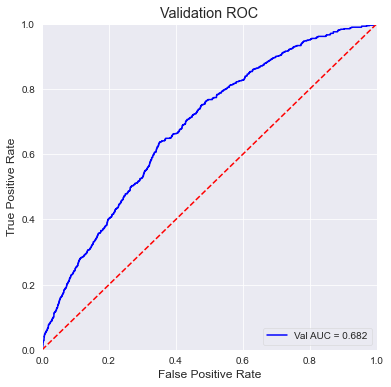

In [536]:
#AUC可视化
lgb_origi_pre=lgb_origi.predict(x_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, lgb_origi_pre)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 根据特征重要性筛选一下，按照特征名称和重要性组成一个数据集。筛选出特征重要性为0的特征并去除。

In [537]:
full_third_party.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29687 entries, 0 to 29686
Columns: 5224 entries, third_max_10 to Idx
dtypes: float64(5224)
memory usage: 1.2 GB


In [538]:
feature_name_list=list(lgb_origi.feature_name())
feature_importance_list=list(lgb_origi.feature_importance())
feature_data=pd.DataFrame({'feature_name':feature_name_list,'feature_importance':feature_importance_list})
feature_data=feature_data.sort_values(by='feature_importance',ascending=False).reset_index(drop=True)

In [539]:
feature_zero=list(feature_data[feature_data['feature_importance']==0]['feature_name'])
full_third_party=full_third_party.drop(feature_zero,axis=1)

In [540]:
full_third_party.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29687 entries, 0 to 29686
Columns: 1048 entries, third_max_10 to Idx
dtypes: float64(1048)
memory usage: 237.4 MB


### 拼接Master与third_party的衍生数据集。

In [544]:
Master_full = Master.copy()

In [545]:
Master_full = pd.merge(Master_full,full_third_party,on='Idx',how='left')

In [557]:
x=Master_full.drop('target',1)
y=Master['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

#lightgbm
lgb_train = lgb.Dataset(x_train,y_train)
lgb_test = lgb.Dataset(x_test,y_test,reference=lgb_train)
lgb_origi_params = {
              'boosting_type':'gbdt',
              'max_depth':-1,
              'num_leaves':31,
              'bagging_fraction':1.0,
              'feature_fraction':1.0,
              'learning_rate':0.05,
              'metric': 'auc'}
start = time.time()
lgb_origi = lgb.train(train_set=lgb_train,
                      early_stopping_rounds=10,
                      num_boost_round=900,
                      params=lgb_origi_params,
                      valid_sets=lgb_test)
end = time.time()
print('lightgbm运行时间为{}秒'.format(round(end-start,0)))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287432
[LightGBM] [Info] Number of data points in the train set: 20780, number of used features: 1254
[LightGBM] [Info] Start training from score 0.073436
[1]	valid_0's auc: 0.618717
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.651617
[3]	valid_0's auc: 0.665221
[4]	valid_0's auc: 0.670436
[5]	valid_0's auc: 0.674329
[6]	valid_0's auc: 0.675876
[7]	valid_0's auc: 0.679306
[8]	valid_0's auc: 0.679335
[9]	valid_0's auc: 0.680931
[10]	valid_0's auc: 0.68128
[11]	valid_0's auc: 0.680297
[12]	valid_0's auc: 0.684331
[13]	valid_0's auc: 0.685297
[14]	valid_0's auc: 0.687581
[15]	valid_0's auc: 0.691532
[16]	valid_0's auc: 0.690919
[17]	valid_0's auc: 0.69415
[18]	valid_0's auc: 0.694643
[19]	valid_0's auc: 0.694493
[20]	valid_0's auc: 0.696344
[21]	valid_0's auc: 0

## 三、处理LogInfo和Update表
### LogInfo是一个快照表，不需要考虑缺失的问题，也没有需要清洗的特征，直接做衍生即可。

In [625]:
LogInfo.head()

,Idx,Listinginfo1,LogInfo1,LogInfo2,LogInfo3
0,10001,2014-03-05,107,6,2014-02-20
1,10001,2014-03-05,107,6,2014-02-23
2,10001,2014-03-05,107,6,2014-02-24
3,10001,2014-03-05,107,6,2014-02-25
4,10001,2014-03-05,107,6,2014-02-27


In [417]:
data1 = Master.copy()
data2 = LogInfo.copy()
data3 = Userupdate.copy()

In [627]:
# 累计登陆次数
LogCnt=LogInfo.groupby('Idx',as_index=False)['Listinginfo1'].count().rename(columns={'Listinginfo1':'LogCnt'})

In [636]:
# 最近一次的登录时间和借款时间的差
LogInfo['Listinginfo1']=pd.to_datetime(LogInfo['Listinginfo1'])
LogInfo['LogInfo3']=pd.to_datetime(LogInfo['LogInfo3'])
LogTimeSpan=LogInfo.groupby('Idx',as_index=False).agg({'Listinginfo1':np.max,'LogInfo3':np.max})
LogTimeSpan['LogTimespan']=LogTimeSpan['Listinginfo1']-LogTimeSpan['LogInfo3']
LogTimeSpan['LogTimespan']=LogTimeSpan['LogTimespan'].map(lambda x:x.days)
LogTimeSpan=LogTimeSpan[['Idx','LogTimespan']]#只留下衍生的

In [629]:
# 平均登录时间差
LogTimeSpanAverage=LogInfo.sort_values(['Idx','LogInfo3'])#默认升序
LogTimeSpanAverage['LogInfo4']=LogTimeSpanAverage.groupby('Idx')['LogInfo3'].apply(lambda x:x.shift(1))
LogTimeSpanAverage['LogTimeSpanAverage']=LogTimeSpanAverage['LogInfo3']-LogTimeSpanAverage['LogInfo4']
LogTimeSpanAverage['LogTimeSpanAverage']=LogTimeSpanAverage['LogTimeSpanAverage'].map(lambda x:x.days)
LogTimeSpanAverage['LogTimeSpanAverage']=LogTimeSpanAverage['LogTimeSpanAverage'].fillna(0)
LogTimeSpanAverage=LogTimeSpanAverage.groupby('Idx',as_index=False)['LogTimeSpanAverage'].mean()

In [630]:
# 每个样本出现次数最多的操作代码和类别
MaxLogInfo1Cnt=LogInfo.groupby(['Idx','LogInfo1'],as_index=False)['LogInfo2'].count().rename(columns={'LogInfo1':'MaxLogInfo1','LogInfo2':'cnt'})
MaxLogInfo1Cnt=MaxLogInfo1Cnt.sort_values('cnt',ascending=False).groupby(['Idx'],as_index=False).head(1)
MaxLogInfo1Cnt=MaxLogInfo1Cnt.drop(['cnt'],axis=1)
MaxLogInfo2Cnt=LogInfo.groupby(['Idx','LogInfo2'],as_index=False)['LogInfo1'].count().rename(columns={'LogInfo2':'MaxLogInfo2','LogInfo1':'cnt'})
MaxLogInfo2Cnt=MaxLogInfo2Cnt.sort_values('cnt',ascending=False).groupby(['Idx'],as_index=False).head(1)
MaxLogInfo2Cnt=MaxLogInfo2Cnt.drop(['cnt'],axis=1)

In [631]:
# 每个样本出现次数最少的操作代码和类别
MinLogInfo1Cnt=LogInfo.groupby(['Idx','LogInfo1'],as_index=False)['LogInfo2'].count().rename(columns={'LogInfo1':'MinLogInfo1','LogInfo2':'cnt'})
MinLogInfo1Cnt=MinLogInfo1Cnt.sort_values('cnt').groupby(['Idx'],as_index=False).head(1)
MinLogInfo1Cnt=MinLogInfo1Cnt.drop(['cnt'],axis=1)
MinLogInfo2Cnt=LogInfo.groupby(['Idx','LogInfo2'],as_index=False)['LogInfo1'].count().rename(columns={'LogInfo2':'MinLogInfo2','LogInfo1':'cnt'})
MinLogInfo2Cnt=MinLogInfo2Cnt.sort_values('cnt').groupby(['Idx'],as_index=False).head(1)
MinLogInfo2Cnt=MinLogInfo2Cnt.drop(['cnt'],axis=1)

### 将以上衍生特征合并

In [632]:
LogInfo_new=pd.merge(LogCnt,LogTimeSpan,on='Idx',how='left')
LogInfo_new=pd.merge(LogInfo_new,LogTimeSpanAverage,on='Idx',how='left')
LogInfo_new=pd.merge(LogInfo_new,MaxLogInfo1Cnt,on='Idx',how='left')
LogInfo_new=pd.merge(LogInfo_new,MaxLogInfo2Cnt,on='Idx',how='left')
LogInfo_new=pd.merge(LogInfo_new,MinLogInfo1Cnt,on='Idx',how='left')
LogInfo_new=pd.merge(LogInfo_new,MinLogInfo2Cnt,on='Idx',how='left')

### 先把'UserupdateInfo1'的字母大小写统一一下。

In [637]:
Userupdate['UserupdateInfo1']=Userupdate['UserupdateInfo1'].map(lambda x:x.lower())

In [425]:
# 每个用户资料更改的总次数
UpdateCnt=Userupdate.groupby(['Idx'],as_index=False)['UserupdateInfo1'].count().rename(columns={'UserupdateInfo1':'UpdateCnt'})

In [638]:
# 平均更新时间差
Userupdate['ListingInfo1']=pd.to_datetime(Userupdate['ListingInfo1'])
Userupdate['UserupdateInfo2']=pd.to_datetime(Userupdate['UserupdateInfo2'])
UpdateTimeSpanAverage=Userupdate.sort_values(['Idx','UserupdateInfo2'])#默认升序
UpdateTimeSpanAverage['UserupdateInfo3']=UpdateTimeSpanAverage.groupby('Idx')['UserupdateInfo2'].apply(lambda x:x.shift(1))
UpdateTimeSpanAverage['UpdateTimeSpanAverage']=UpdateTimeSpanAverage['UserupdateInfo2']-UpdateTimeSpanAverage['UserupdateInfo3']
UpdateTimeSpanAverage['UpdateTimeSpanAverage']=UpdateTimeSpanAverage['UpdateTimeSpanAverage'].map(lambda x:x.days)
UpdateTimeSpanAverage['UpdateTimeSpanAverage']=UpdateTimeSpanAverage['UpdateTimeSpanAverage'].fillna(0)
UpdateTimeSpanAverage=UpdateTimeSpanAverage.groupby('Idx',as_index=False)['UpdateTimeSpanAverage'].mean()
UpdateTimeSpanAverage=UpdateTimeSpanAverage[['Idx','UpdateTimeSpanAverage']]

In [639]:
# 最近一次资料更新时间和成交时间的时间差
UpdateTimeSpan=Userupdate.groupby('Idx',as_index=False).agg({'ListingInfo1':np.max,'UserupdateInfo2':np.max})
UpdateTimeSpan['UpdateTimeSpan']=UpdateTimeSpan['ListingInfo1']-UpdateTimeSpan['UserupdateInfo2']
UpdateTimeSpan['UpdateTimeSpan']=UpdateTimeSpan['UpdateTimeSpan'].map(lambda x:x.days)
UpdateTimeSpan=UpdateTimeSpan[['Idx','UpdateTimeSpan']]#只留下衍生的

In [640]:
# 更新过最多次数的内容
MaxUpdateCnt=Userupdate.groupby(['Idx','UserupdateInfo1'],as_index=False)['UserupdateInfo2'].count().rename(columns={'UserupdateInfo1':'MaxUserupdateInfo1','UserupdateInfo2':'cnt'})
MaxUpdateCnt=MaxUpdateCnt.sort_values('cnt',ascending=False).groupby(['Idx'],as_index=False).head(1)
MaxUpdateCnt=MaxUpdateCnt.drop(['cnt'],axis=1)

In [641]:
# 更新过最少次数的内容
MinUpdateCnt=Userupdate.groupby(['Idx','UserupdateInfo1'],as_index=False)['UserupdateInfo2'].count().rename(columns={'UserupdateInfo1':'MinUserupdateInfo1','UserupdateInfo2':'cnt'})
MinUpdateCnt=MinUpdateCnt.sort_values('cnt').groupby(['Idx'],as_index=False).head(1)
MinUpdateCnt=MinUpdateCnt.drop(['cnt'],axis=1)

In [642]:
UpdateInfo=pd.merge(UpdateCnt,MaxUpdateCnt,on='Idx',how='left')
UpdateInfo=pd.merge(UpdateInfo,MinUpdateCnt,on='Idx',how='left')
UpdateInfo=pd.merge(UpdateInfo,UpdateTimeSpan,on='Idx',how='left')
UpdateInfo=pd.merge(UpdateInfo,UpdateTimeSpanAverage,on='Idx',how='left')

In [643]:
# 衍生过程种产生了一些分类特征，进行序列化。
UpdateInfo_category_list=[]
for i in UpdateInfo.columns:
    if UpdateInfo[i].dtype=='object':
        UpdateInfo_category_list.append(i)
for i in UpdateInfo_category_list:
    lbl = preprocessing.LabelEncoder()
    UpdateInfo[i] = lbl.fit_transform(list(UpdateInfo[i].values))

### 合并所有数据

In [645]:
full_data=pd.merge(Master_full,LogInfo_new,on='Idx',how='left')
full_data=pd.merge(full_data,UpdateInfo,on='Idx',how='left')
full_data.drop(['Idx','ListingInfo'],axis=1,inplace=True)

In [647]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29687 entries, 0 to 29686
Columns: 1269 entries, UserInfo_1 to UpdateTimeSpanAverage
dtypes: float64(1200), int64(69)
memory usage: 287.6 MB


### 模型建立

In [652]:
x = full_data.drop('target',1)
y = full_data['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [653]:
lgb_train = lgb.Dataset(x_train,y_train)
lgb_test = lgb.Dataset(x_test,y_test,reference=lgb_train)
lgb_full_params = {
              'boosting_type':'gbdt',
              'max_depth':-1,
              'num_leaves':31,
              'bagging_fraction':1.0,
              'feature_fraction':1.0,
              'learning_rate':0.05,
              'metric': 'auc'}
start = time.time()
lgb_full = lgb.train(train_set=lgb_train,
                      early_stopping_rounds=100,
                      num_boost_round=900,
                      categorical_feature=category_list,
                      params=lgb_full_params,
                      valid_sets=lgb_test)
end = time.time()
print('运行时间为{}秒'.format(round(end-start,0)))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288106
[LightGBM] [Info] Number of data points in the train set: 20780, number of used features: 1264
[LightGBM] [Info] Start training from score 0.073436
[1]	valid_0's auc: 0.617593
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.650751
[3]	valid_0's auc: 0.668688
[4]	valid_0's auc: 0.672839
[5]	valid_0's auc: 0.678225
[6]	valid_0's auc: 0.680434
[7]	valid_0's auc: 0.680454
[8]	valid_0's auc: 0.680366
[9]	valid_0's auc: 0.682322
[10]	valid_0's auc: 0.683428
[11]	valid_0's auc: 0.68496
[12]	valid_0's auc: 0.683251
[13]	valid_0's auc: 0.687662
[14]	valid_0's auc: 0.691454
[15]	valid_0's auc: 0.69368
[16]	valid_0's auc: 0.694697
[17]	valid_0's auc: 0.697568
[18]	valid_0's auc: 0.697948
[19]	valid_0's auc: 0.698907
[20]	valid_0's auc: 0.699883
[21]	valid_0's auc: 

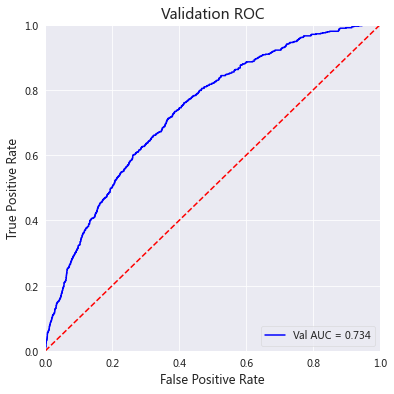

In [654]:
#AUC可视化
lgb_full_pre=lgb_full.predict(x_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, lgb_full_pre)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 调整参数
### 使用lgb自带的cv来计算，先限定learning_rate为0.1，这样调整别的参数的时候可以迭代得更快一些。
### num_boost_round（n_estimators）

In [657]:
lgb_train = lgb.Dataset(x_train,y_train)


In [658]:
start = time.time()
base_parmas={'boosting_type':'gbdt',
             'learning_rate':0.1,
             'num_leaves':31,
             'max_depth':-1,
             'bagging_fraction':0.7,
             'feature_fraction':0.7,
             'lambda_l1':0,
             'lambda_l2':0,
             'min_data_in_leaf':20,
             'min_sum_hessian_inleaf':0.001,
             'metric':'auc'}
cv_result = lgb.cv(train_set=lgb_train,
                   num_boost_round=200,
                   early_stopping_rounds=10,
                   nfold=5,
                   stratified=True,
                   shuffle=True,
                   params=base_parmas,
                   metrics='auc',
                   seed=0)
end = time.time()
print('迭代次数:{}'.format(len(cv_result['auc-mean'])))
print('交叉验证的AUC:{}'.format(max(cv_result['auc-mean'])))
print('运行时间为{}秒'.format(round(end-start,0)))

[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288107
[LightGBM] [Info] Number of data points in the train set: 16624, number of used features: 1264
[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288107
[LightGBM] [Info] Number of data points in the train set: 16624, number of used features: 1264
[LightGBM] [Warning] Unknown p

### 需要注意一下的是，除了获取上面的获取num_boost_round时候用的是原生的lightgbm（因为要用自带的cv），下面配合GridSearchCV时必须使用sklearn接口的lightgbm。
### num_leaves

In [661]:
start = time.time()
params1={'num_leaves':list(range(30,60,5))}
model_lgb1=lgb.LGBMClassifier(
             learning_rate=0.1,
             n_estimators=54,
             max_depth=-1,
             bagging_fraction=0.7,
             feature_fraction=0.7,
             lambda_l1=0,
             lambda_l2=0,
             min_data_in_leaf=20,
             min_sum_hessian_inleaf=0.001)
grid_search1=GridSearchCV(estimator=model_lgb1,cv=5,param_grid=params1,n_jobs=-1,scoring='roc_auc')
grid_search1.fit(x_train,y_train)
end = time.time()
print('最优参数为:{}'.format(grid_search1.best_params_))
print('最优分数为:{}'.format(grid_search1.best_score_))
print('运行时间为{}秒'.format(round(end-start,0)))

[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
最优参数为:{'num_leaves': 30}
最优分数为:0.7332896492118776
运行时间为179.0秒


### 在30的基础上再进行细调

In [662]:
start = time.time()
params2={'num_leaves':list(range(25,35,2))}
model_lgb2=lgb.LGBMClassifier(
             learning_rate=0.1,
             n_estimators=54,
             max_depth=-1,
             bagging_fraction=0.7,
             feature_fraction=0.7,
             lambda_l1=0,
             lambda_l2=0,
             min_data_in_leaf=20,
             min_sum_hessian_inleaf=0.001)
grid_search2=GridSearchCV(estimator=model_lgb2,cv=5,param_grid=params2,n_jobs=-1,scoring='roc_auc')
grid_search2.fit(x_train,y_train)
end = time.time()
print('最优参数为:{}'.format(grid_search2.best_params_))
print('最优分数为:{}'.format(grid_search2.best_score_))
print('运行时间为{}秒'.format(round(end-start,0)))

最优参数为:{'num_leaves': 29}
最优分数为:0.7355144389414836
运行时间为122.0秒


### 最后的参数num_leaves=29。
### bagging_fraction，feature_fraction

In [665]:
start = time.time()
params3={'bagging_fraction':[i/10 for i in range(4,11,1)],'feature_fraction':[i/10 for i in range(4,11,1)]}
model_lgb3=lgb.LGBMClassifier(
             learning_rate=0.1,
             n_estimators=50,
             num_leaves=29,
             max_depth=-1,
             lambda_l1=0,
             lambda_l2=0,
             min_data_in_leaf=20,
             min_sum_hessian_inleaf=0.001)
grid_search3=GridSearchCV(estimator=model_lgb3,cv=5,param_grid=params3,n_jobs=-1,scoring='roc_auc')
grid_search3.fit(x_train,y_train)
end = time.time()
print('最优参数为:{}'.format(grid_search3.best_params_))
print('最优分数为:{}'.format(grid_search3.best_score_))
print('运行时间为{}秒'.format(round(end-start,0)))

最优参数为:{'bagging_fraction': 0.4, 'feature_fraction': 0.8}
最优分数为:0.7385931474149334
运行时间为933.0秒


### lambda_l1，lambda_l2

In [666]:
start = time.time()
params4={'lambda_l1':[0,0.001,0.01,0.03,0.08,0.3,0.5],'lambda_l2':[0,0.001,0.01,0.03,0.08,0.3,0.5]}
model_lgb4=lgb.LGBMClassifier(
             learning_rate=0.1,
             n_estimators=50,
             num_leaves=29,
             max_depth=-1,
             bagging_fraction=0.4,
             feature_fraction=0.8,
             min_data_in_leaf=20,
             min_sum_hessian_inleaf=0.001)
grid_search4=GridSearchCV(estimator=model_lgb4,cv=5,param_grid=params4,n_jobs=-1,scoring='roc_auc')
grid_search4.fit(x_train,y_train)
end = time.time()
print('最优参数为:{}'.format(grid_search4.best_params_))
print('最优分数为:{}'.format(grid_search4.best_score_))
print('运行时间为{}秒'.format(round(end-start,0)))

最优参数为:{'lambda_l1': 0, 'lambda_l2': 0.001}
最优分数为:0.7409056343205832
运行时间为2465.0秒


### min_data_in_leaf,min_sum_hessian_inleaf

In [667]:
start = time.time()
params5={'min_data_in_leaf':[i for i in range(10,30,2)],'min_sum_hessian_inleaf':[i/1000 for i in range(1,5,1)]}
model_lgb5=lgb.LGBMClassifier(
             learning_rate=0.1,
             n_estimators=50,
             num_leaves=29,
             max_depth=-1,
             bagging_fraction=0.4,
             feature_fraction=0.8,
             lambda_l1=0,
             lambda_l2=0.001)
grid_search5=GridSearchCV(estimator=model_lgb5,cv=5,param_grid=params5,n_jobs=-1,scoring='roc_auc')
grid_search5.fit(x_train,y_train)
end = time.time()
print('最优参数为:{}'.format(grid_search5.best_params_))
print('最优分数为:{}'.format(grid_search5.best_score_))
print('运行时间为{}秒'.format(round(end-start,0)))

最优参数为:{'min_data_in_leaf': 20, 'min_sum_hessian_inleaf': 0.001}
最优分数为:0.7409056343205832
运行时间为819.0秒


### 上面几个确定好了以后，我们设置一个比较小的learning_rate 0.005，来确定最终的num_boost_round

In [668]:
start = time.time()
final_parmas={'boosting_type':'gbdt',
             'learning_rate':0.005,
             'num_leaves':29,
             'max_depth':-1,
             'bagging_fraction':0.4,
             'feature_fraction':0.8,
             'lambda_l1':0,
             'lambda_l2':0.001,
             'min_data_in_leaf':20,
             'min_sum_hessian_inleaf':0.001,
             'metric':'auc'}
cv_result = lgb.cv(train_set=lgb_train,
                   num_boost_round=2000,
                   early_stopping_rounds=20,
                   nfold=5,
                   stratified=True,
                   shuffle=True,
                   params=final_parmas,
                   metrics='auc',
                   seed=0)
end = time.time()
print('最大的迭代次数:{}'.format(len(cv_result['auc-mean'])))
print('交叉验证的AUC:{}'.format(max(cv_result['auc-mean'])))
print('运行时间为{}秒'.format(round(end-start,0)))

[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288107
[LightGBM] [Info] Number of data points in the train set: 16624, number of used features: 1264
[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288107
[LightGBM] [Info] Number of data points in the train set: 16624, number of used features: 1264
[LightGBM] [Warning] Unknown p

### 最优参数已经全部计算好了，我们把它代入模型并直接将AUC可视化，看一下优化以后的结果如何

[LightGBM] [Warning] Unknown parameter: min_sum_hessian_inleaf
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001


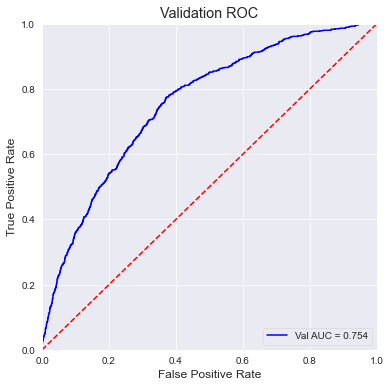

In [670]:
final_model = lgb.LGBMClassifier(learning_rate=0.005,
             n_estimators=1400,
             num_leaves=29,
             max_depth=-1,
             bagging_fraction=0.4,
             feature_fraction=0.8,
             lambda_l1=0,
             lambda_l2=0.001,
             min_data_in_leaf=20,
             min_sum_hessian_inleaf=0.001)
final_model.fit(x_train,y_train)
final_pre= final_model.predict_proba(x_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test,final_pre)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()